# Pseudo-Random Number Generation Algorithms

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## XOR Shift

Output from example C implementation 
from https://en.wikipedia.org/wiki/Xorshift 

In [2]:
test_values = [
    111,
    28437833,
    3204627429,
    3887305882,
    825450314,
    27031239,
    1742667205,
    3030794038,
    458757206,
    596234079,
    1445359534
]

In [3]:
def xorshift32(state):
    # Algorithm "xor" from p. 4 of Marsaglia, "Xorshift RNGs"
    state = (state ^ state << 13) & 0xffffffff;
    state = (state ^ state >> 17) & 0xffffffff;
    state = (state ^ state << 5) & 0xffffffff;
    return state

assert list(map(xorshift32, test_values[:-1])) == test_values[1:]

In [4]:
# This is not reversible!

## Linear congruential generator

This algorithm is reversible

In [5]:
# From: https://stackoverflow.com/a/58867375/1609514

def LCG(a, c, m, seed):     
    xi = seed
    while True:
        xf = (a * xi + c) % m
        xi = xf
        yield xf

def random_sample(n, interval, seed = 20200420162000):
    lower, upper = interval[0], interval[1]
    sample = []
    glibc = LCG(1103515245, 12345, 2 ** 32, seed)       # parameters as in GNU C Library

    for i in range(n):
        observation = (upper - lower) * (next(glibc) / (2 ** 32 - 1)) + lower
        sample.append(int(observation))

    return sample

In [6]:
sample = random_sample(10, [30, 90])
sample

[54, 77, 41, 61, 74, 49, 65, 66, 86, 39]

## Euclidian Algorithm
(this is needed for the next algorithm)

Based on code from
- http://anh.cs.luc.edu/331/notes/xgcd.pdf

In [7]:
def gcd(a, b):
    """Greatest common denominator of a and b.
    """
    while b:
        a, b = b, a % b
    return a

assert gcd(2, 1) == 1
assert gcd(36, 96) == 12
assert gcd(96, 36) == 12
assert gcd(46, 240) == 2
assert gcd(1071, 462) == 21

## Extended Euclidian Algorithm

the extended Euclidean algorithm is an extension to the Euclidean algorithm, and computes, in addition to the greatest common divisor (gcd) of integers $a$ and $b$, also the coefficients of Bézout's identity, which are integers $x$ and $y$ such that

$$ax+by=\gcd(a,b)$$


Pseudo-code from:
- https://en.wikipedia.org/wiki/Extended_Euclidean_algorithm#Pseudocode

In [8]:
def extended_gcd(a, b):
    old_r, r = a, b
    old_s, s = 1, 0
    old_t, t = 0, 1
    
    while r != 0:
        quotient = old_r // r
        old_r, r = r, old_r - quotient * r
        old_s, s = s, old_s - quotient * s
        old_t, t = t, old_t - quotient * t
    
    return {
        "Bézout coefficients": (old_s, old_t),
        "greatest common divisor": old_r,
        "quotients by the gcd:": (t, s)
    }

assert extended_gcd(46, 240) == {
    'Bézout coefficients': (47, -9),
    'greatest common divisor': 2,
    'quotients by the gcd:': (23, -120)
}

In [9]:
def extended_gcd(a, b):
    old_r, r = a, b
    old_s, s = 1, 0
    
    while r != 0:
        quotient = old_r // r
        old_r, r = r, old_r - quotient * r
        old_s, s = s, old_s - quotient * s
    
    if b != 0:
        bezout_t = (old_r - old_s * a) // b
    else:
        bezout_t = 0
    
    return {
        "Bézout coefficients": (old_s, bezout_t),
        "greatest common divisor": old_r
    }

# See example from wikipedia.org
a, b = (46, 240)
ex = extended_gcd(a, b)
assert ex == {
    'Bézout coefficients': (47, -9), 
    'greatest common divisor': 2
}
assert np.sum(np.multiply(ex['Bézout coefficients'], (a, b))) == ex['greatest common divisor']

In [10]:
def xgcd(a, b):
    """Extended Euclidean algorithm to determine the
    greatest common divisor of a and b, as well as the
    as Bézout coefficients, x and y in the equation:
    
        ax + by = gcd(a, b)
    
    returns gcd(a, b), x, y
    """
    prevx, x = 1, 0
    prevy, y = 0, 1
    while b:
        q = a // b
        x, prevx = prevx - q*x, x
        y, prevy = prevy - q*y, y
        a, b = b, a % b
    return a, prevx, prevy 

# See example from wikipedia.org
a, b = (46, 240)
gcd, x, y = xgcd(a, b)
assert (gcd, x, y) == (2, 47, -9)
assert np.sum(np.multiply((x, y), (a, b))) == gcd
assert xgcd(b, a) == (gcd, y, x)

In [11]:
def xgcd_x(a, b):
    """Extended Euclidean algorithm to determine the integer x
    in the equation:
    
        ax + by = gcd(a, b)
    
    where gcd(a, b) is the greatest common divisor of a and b.
    
    x and y are known as Bézout coefficients.
    """
    x_prev, x = 1, 0
    
    while b:
        q = a // b
        x, x_prev = x_prev - q*x, x
        a, b = b, a % b
    
    return x_prev

assert xgcd_x(46, 240) == 47

## Reversible LCG

Based on this C++ code from https://github.com/bobbaluba/rlcg/blob/master/include/rlcg.hpp:

In [12]:
def extendedEuclidX(a, b):
    return 1 if b == 0 else extendedEuclidY(b, a - b * (a // b));

def extendedEuclidY(a, b):
    """Extended Euclidean algorithm to determine the integer y
    in the equation:
    
        ax + by = gcd(a, b)
    
    where gcd(a, b) is the greatest common divisor of a and b.
    """
    if b == 0:
        return 0
    else:
        return (extendedEuclidX(b, a - b * (a // b)) - (a // b) 
                * extendedEuclidY(b, a - b * (a // b)))

In [14]:
def is_power_of_two(x):
    return (x & (x - 1)) == 0

assert all(is_power_of_two(x) for x in [0, 1, 2, 8, 256])
assert not any(is_power_of_two(x) for x in [-1, 3, 9, 257])

a_inverse_stored = {} 

# Pre-computed values for faster execution
def get_a_inverse_value(a, b):
    """Returns a pre-calculated value of a_inverse if one
    exists otherwise calculates it using extendedEuclidX(a, b).
    """
    if (a, b) in a_inverse_stored:
        return a_inverse_stored[(a, b)]
    else:
        x = xgcd_x(a, b)
        a_inverse_stored[(a, b)] = x
        return x


class ReversibleLCG:
    """Reversible Linear Congruential Generator
    
    The LCG is a type of pseudo-random number generator that
    supports generating random numbers in two directions (i.e.
    forwards and backwards).
    
    The internal state of the generator is a single integer, x.
    The following formula is used to produce the next state
    value in the sequence:
    
        nextx = (a * x + c) % m
    
    where a, c, and m are constants. With appropriate choice
    of these parameters, the period of the sequence is long.
    
    The d least-significant bits of x are removed and the
    output value returned by the generator is given by
    
        x >> d
    
    This truncation technique produces sequences with longer
    periods and statistically better values.  The values
    generated are in the range 0 to ((m-1) >> d).
    
    Arguments
    ----------
    seed : int
        Initial value of x to seed the random number generator.
    m : int
        Modulus.
    a : int
        Multiplicand.
    c : int
        Increment.
    d : int
        Least significant bits to discard.
    a_inverse : int
        The value of `a` used to step in the reverse direction.
    max : int
        Maximum value that can be produced.
    """

    def __init__(self, seed, m=1<<63, a=6364136223846793005, 
                 c=1442695040888963407, d=32):
        self.x = seed
        assert is_power_of_two(m), "M must be a power of two"
        self._m = m
        self._a = a
        self._c = c
        self._d = d
        self._a_inverse = get_a_inverse_value(self._a, self._m)
        self.forward = True

    @property
    def m(self):
        return self._m

    @property
    def a(self):
        return self._a

    @property
    def c(self):
        return self._c

    @property
    def d(self):
        return self._d

    @property
    def a_inverse(self):
        return self._a_inverse

    @property
    def x(self):
        return self._x

    @x.setter
    def x(self, value):
        self._x = value

    @property
    def max(self):
        return (self._m - 1) >> self._d

    def __iter__(self):
        return self

    def __next__(self):
        if self.forward:
            return self.next()
        else:
            return self.prev()

    def reverse(self):
        self.forward = not self.forward

    def next(self):
        """Compute and return next value in sequence."""
        # nextx = (a * x + c) % m
        self._x = (self._a * self._x + self._c) & (self._m - 1)
        return self._x >> self._d

    def prev(self):
        """Compute and return previous value in sequence."""
        # prevx = (ainverse * (x - c)) mod m
        self._x = self._a_inverse * (self._x - self._c) & (self._m - 1)
        return self._x >> self._d


In [15]:
# Values produced by rlcg.hpp with seed = 42
test_values = [0, 293047021, 968358053, 1773127077, 560055359, 773728940]

In [16]:
# Example use: as an iterator
rng = ReversibleLCG(42)
for i, x in enumerate(iter(rng)):
    print(x)
    assert x == test_values[i + 1]
    if i == 4:
        break

293047021
968358053
1773127077
560055359
773728940


In [17]:
# Reverse and go back
rng.reverse()
assert rng.forward is False
for i, x in enumerate(iter(rng)):
    print(x)
    assert x == test_values[4 - i]
    if i == 4:
        break

560055359
1773127077
968358053
293047021
0


In [18]:
# Using the class methods directly
rng = ReversibleLCG(42)
assert [rng.next() for i in range(5)] == test_values[1:]
assert [rng.prev() for i in range(5)] == list(reversed(test_values[:-1]))

In [19]:
rng = ReversibleLCG(42)
rng.a, rng.a_inverse

(6364136223846793005, -4568919932995229531)

In [20]:
for i in range(5):
    print(rng.next())

293047021
968358053
1773127077
560055359
773728940


In [21]:
# How to reverse it using parameters
N = 1 << 64
m, a, c, d, a_inverse = rng.m, rng.a, rng.c, rng.d, rng.a_inverse
m, a, c, d = m, a_inverse & (N - 1), -c*a_inverse & (N - 1), d
rng = ReversibleLCG(rng.x, m=m, a=a, c=c, d=d)
rng.a, rng.a_inverse

(13877824140714322085, -2859235813007982803)

In [22]:
for i in range(5):
    print(rng.next())

560055359
1773127077
968358053
293047021
0


In [23]:
a_inverse_stored

{(6364136223846793005, 9223372036854775808): -4568919932995229531,
 (13877824140714322085, 9223372036854775808): -2859235813007982803}

Max: 2147483647


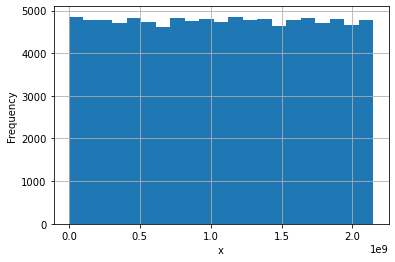

In [24]:
# Using numpy
rng = ReversibleLCG(42)
print(f"Max: {rng.max}")
sample = np.fromiter(rng, dtype='uint32', count=100000)
plt.hist(sample, bins=21)
plt.xlabel('x')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## Reversible LCG - Numpy version

In [25]:
def nn(x):
    return x + 1

list(map(nn, [1, 2, 3]))

[2, 3, 4]

In [26]:
from functools import reduce

def nn(x1, x2):
    return x1 + x2

reduce(nn, [1, 2, 3])

6

In [27]:
# modulus
M = 1 << 63

# multiplicand
A = 6364136223846793005
A_inverse = 13877824140714322085

# increment C
C = 1442695040888963407

# least significant bits to discard
D = 32


def rng_lcg(x, m, a, c):
    while True:
        x = (a*x + c) & (m - 1)
        yield x


rng = rng_lcg(42, M, A, C)
x = np.fromiter(rng, dtype='uint64', count=10)
x >> D

array([ 293047021,  968358053, 1773127077,  560055359,  773728940,
        112652313,   93461938,  654789421, 2035646332,  106512251],
      dtype=uint64)

In [29]:

class ReversibleLCG_vec(ReversibleLCG):
    """Reversible Linear Congruential Generator with additional
    vectorized methods.
    
    The LCG is a type of pseudo-random number generator that
    supports generating random numbers in two directions (i.e.
    forwards and backwards).
    """

    def __init__(self, seed):
        super().__init__(seed)
    
    def _x_generator(x, m, a, c):
        while True:
            x = (a*x + c) & (m - 1)
            yield x
    
    def __getitem__(self, key):
        pass
    
    

## General bidirectional iterator

This was my answer to this stackoverflow question:
- https://stackoverflow.com/a/65536300/1609514

This is an example of a bi-directional iterator which simply counts up or down.

In [30]:
class BidirectionalCounter:
    """An iterator that can count in two directions (up
    and down).
    """

    def __init__(self, start):
        self.forward = True
        # Code to initialize the sequence
        self.x = start

    def __iter__(self):
        return self

    def __next__(self):
        if self.forward:
            return self.next()
        else:
            return self.prev()
    
    def reverse(self):
        self.forward = not self.forward
        
    def next(self):
        """Compute and return next value in sequence.
        """
        # Code to go forward
        self.x += 1
        return self.x
    
    def prev(self):
        """Compute and return previous value in sequence.
        """
        # Code to go backward
        self.x -= 1
        return self.x

In [31]:
my_counter = BidirectionalCounter(10)
print(next(my_counter))
print(next(my_counter))
my_counter.reverse()
print(next(my_counter))
print(next(my_counter))

11
12
11
10


In [32]:
from itertools import repeat

my_counter = BidirectionalCounter(0)
print([next(my_counter) for _ in range(10)])
my_counter.forward = False
print([next(my_counter) for _ in range(10)])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


In [33]:
my_counter = BidirectionalCounter(100)
np.fromiter(my_counter, dtype=int, count=10)

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110])